<a href="https://colab.research.google.com/github/kadilrahman/NLP-english-french/blob/master/encoder_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "tensorflow-text>=2.10"
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
!gdown 1HQHuxkpIepB3OeUUfkD-sUcZKXJ92H7Z

Downloading...
From: https://drive.google.com/uc?id=1HQHuxkpIepB3OeUUfkD-sUcZKXJ92H7Z
To: /content/fra-eng.zip
100% 7.76M/7.76M [00:00<00:00, 58.2MB/s]


In [ ]:
import pathlib
import zipfile

# Define the path to your existing ZIP file in Google Colab
path_to_zip = '/content/fra-eng.zip'  # Replace with the actual path

# Define the directory where you want to extract the file
extracted_dir = '/content'  # Replace with your desired directory

# Unzip the file
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Define the path to the extracted text file
path_to_file = pathlib.Path(extracted_dir) / 'fra.txt'



In [ ]:
import numpy as np
from pathlib import Path

def load_data(path):
    text = Path(path).read_text(encoding='utf-8')

    lines = text.strip().split('\n')
    english_sentences = []
    french_sentences = []

    for line in lines:
        parts = line.split('\t')
        if len(parts) < 2:
            print(f"Skipped line: {line}")
            continue  # Skip this line and move to the next one
        english_sentences.append(parts[0])
        french_sentences.append(parts[1])

    return np.array(english_sentences), np.array(french_sentences)

# Usage
target_raw, context_raw = load_data('/content/fra.txt')

# For testing, print out the first few pairs
for i in range(min(5, len(target_raw))):
    print(f"English: {target_raw[i]}")
    print(f"French: {context_raw[i]}")
    print('---')


print(target_raw[-5])
print(context_raw[-5])



English: Go.
French: Va !
---
English: Go.
French: Marche.
---
English: Go.
French: En route !
---
English: Go.
French: Bouge !
---
English: Hi.
French: Salut !
---
Death is something that we're often discouraged to talk about or even think about, but I've realized that preparing for death is one of the most empowering things you can do. Thinking about death clarifies your life.
La mort est une chose qu'on nous décourage souvent de discuter ou même de penser mais j'ai pris conscience que se préparer à la mort est l'une des choses que nous puissions faire qui nous investit le plus de responsabilité. Réfléchir à la mort clarifie notre vie.


In [ ]:
print(context_raw[30])

À l'aide !


In [ ]:
print(target_raw[30])

Help!


In [ ]:
# Define a boolean mask for training data
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

# Filter the data using boolean indexing
train_context = tf.boolean_mask(context_raw, is_train)
train_target = tf.boolean_mask(target_raw, is_train)
val_context = tf.boolean_mask(context_raw, ~is_train)
val_target = tf.boolean_mask(target_raw, ~is_train)

# Calculate BUFFER_SIZE and BATCH_SIZE
BUFFER_SIZE = len(train_context)  # length of the training dataset
BATCH_SIZE = 64

# Create TensorFlow datasets for training and validation
train_raw = tf.data.Dataset.from_tensor_slices((train_context, train_target))
train_raw = train_raw.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_raw = tf.data.Dataset.from_tensor_slices((val_context, val_target))
val_raw = val_raw.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
len(is_train)

227815

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Tom est parti.' b'Est-ce que tu as un paquet de cartes\xc2\xa0?'
 b'Je ne veux pas devenir chauve tant je suis encore jeune.'
 b'Restons mari\xc3\xa9s.'
 b"L'\xc3\xa9quipe f\xc3\xa9minine de basket-ball a un entra\xc3\xaeneur masculin."], shape=(5,), dtype=string)

tf.Tensor(
[b'Tom has gone away.' b'Do you have a deck of cards?'
 b"I don't want to go bald when I'm still young." b"Let's stay married."
 b"The women's basketball team has a male coach."], shape=(5,), dtype=string)


## Standardization

In [ ]:
example_text = tf.constant('« Êtes-vous prêt à partir ? » demanda-t-elle.')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xab \xc3\x8ates-vous pr\xc3\xaat \xc3\xa0 partir ? \xc2\xbb demanda-t-elle.'
b'\xc2\xab E\xcc\x82tes-vous pre\xcc\x82t a\xcc\x80 partir ? \xc2\xbb demanda-t-elle.'


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

« Êtes-vous prêt à partir ? » demanda-t-elle.
[START] etesvous pret a partir  ?   demandatelle . [END]


## Vectorization

In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'je', 'de', 'a', '?', 'pas']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'i', 'you', 'to', 'the', '?']

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 15, 17, 481, 4, 3], [2, 80, 10, 19, 103, 20, 2402, 6, 1370, 8, 3],
 [2, 5, 11, 46, 9, 611, 1, 529, 5, 27, 111, 361, 4, 3]]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] tom est parti . [END]'

Text(0.5, 1.0, 'Mask')

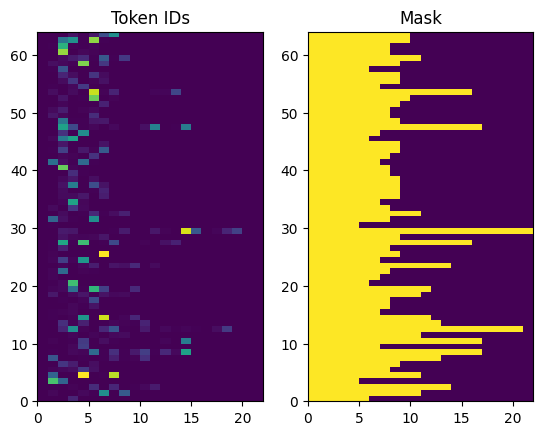

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[   2   32 2500    4    3    0    0    0    0    0]

[   2   50 1077    4    0    0    0    0    0    0]
[  50 1077    4    3    0    0    0    0    0    0]


## Encoder and Decoder

In [ ]:
UNITS = 256

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 23)
Encoder output, shape (batch, s, units): (64, 23, 256)


### Attention layer

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 23, 256)
Target sequence, shape (batch, t, units): (64, 18, 256)
Attention result, shape (batch, t, units): (64, 18, 256)
Attention weights, shape (batch, t, s):    (64, 18, 23)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.9999999 , 1.        , 1.0000001 , 1.        , 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994], dtype=float32)

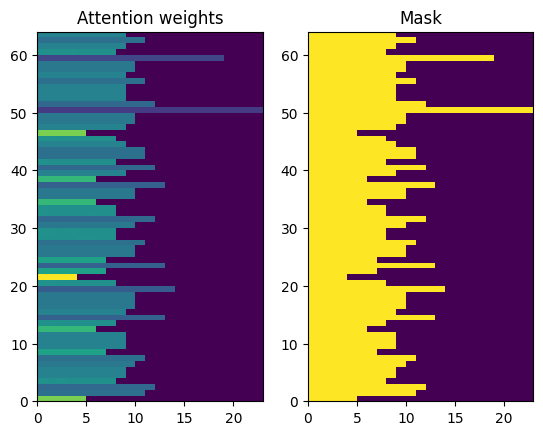

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


### Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

## Tweaking

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 23, 256)
input target tokens shape: (batch, t) (64, 18)
logits shape shape: (batch, target_vocabulary_size) (64, 18, 5000)


### Inference

In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'peacefully mat evil lovely expert balance swim germany smokes afford',
       b'keeping flattered judge alphabet stressful comic dream get proceed skiing',
       b'phoned among detail attend seemed laid nights bark appropriate dark'],
      dtype=object)

## Model

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 23)
Target tokens, shape: (batch, t) (64, 18)
logits, shape: (batch, t, target_vocabulary_size) (64, 18, 5000)


## Training

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

### config for training
make changes here and check

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 16s 351ms/step - loss: 8.5163 - masked_acc: 2.8566e-04 - masked_loss: 8.5163


{'loss': 8.516304969787598,
 'masked_acc': 0.000285658345092088,
 'masked_loss': 8.516304969787598}

In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 90s 753ms/step - loss: 4.9201 - masked_acc: 0.2695 - masked_loss: 4.9201 - val_loss: 3.9721 - val_masked_acc: 0.3683 - val_masked_loss: 3.9721
Epoch 2/100
100/100 [==============================] - 73s 728ms/step - loss: 3.5779 - masked_acc: 0.4217 - masked_loss: 3.5779 - val_loss: 3.2086 - val_masked_acc: 0.4696 - val_masked_loss: 3.2086
Epoch 3/100
100/100 [==============================] - 77s 773ms/step - loss: 2.9818 - masked_acc: 0.4998 - masked_loss: 2.9818 - val_loss: 2.7438 - val_masked_acc: 0.5303 - val_masked_loss: 2.7438
Epoch 4/100
100/100 [==============================] - 74s 739ms/step - loss: 2.6030 - masked_acc: 0.5515 - masked_loss: 2.6030 - val_loss: 2.3826 - val_masked_acc: 0.5794 - val_masked_loss: 2.3826
Epoch 5/100
100/100 [==============================] - 79s 791ms/step - loss: 2.3330 - masked_acc: 0.5864 - masked_loss: 2.3330 - val_loss: 2.1861 - val_masked_acc: 0.6089 - val_masked_loss: 2.1861
Epoch 6/10

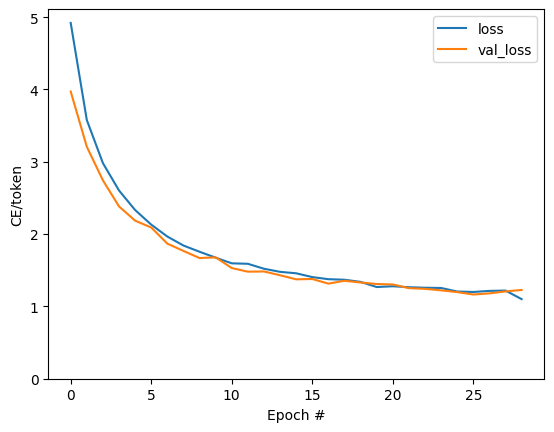

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

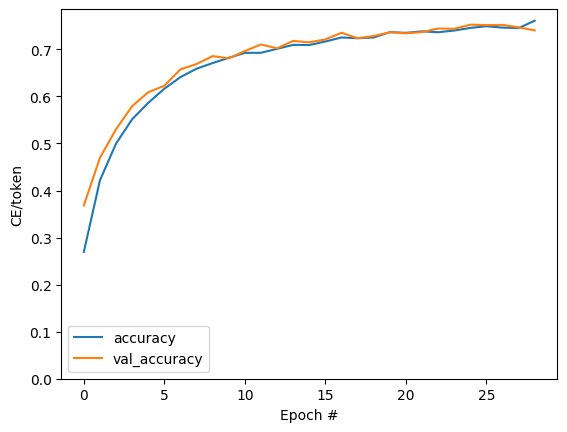

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Translate

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
result = model.translate(['comment vas-tu ?']) # How are you?
result[0].numpy().decode()

'how are you going ? '

In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

<ipython-input-52-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-52-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


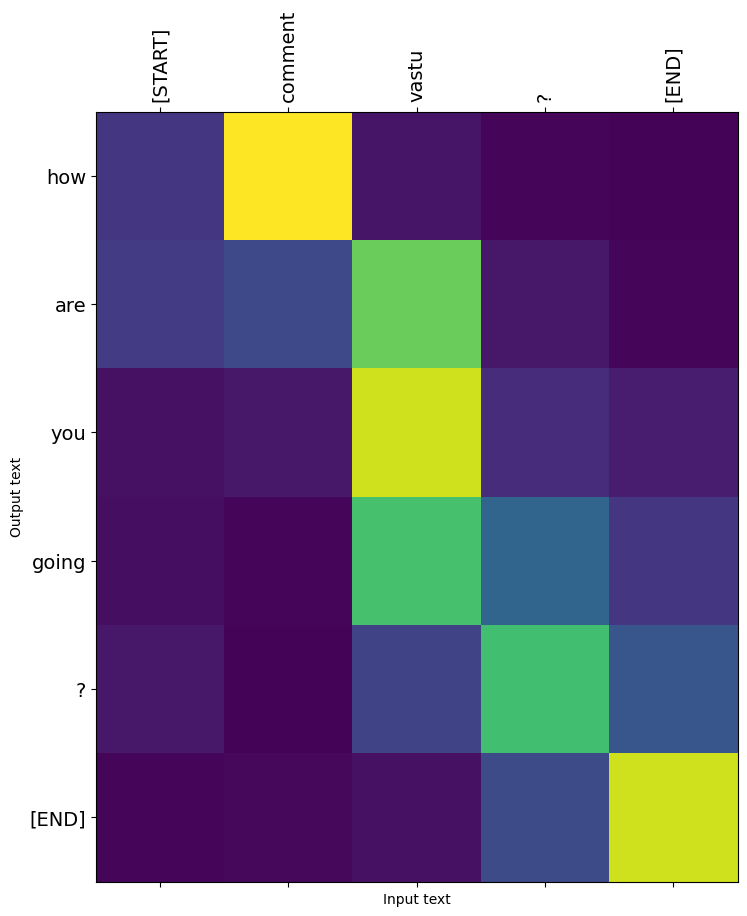

In [ ]:
model.plot_attention('comment vas-tu ?') # how are you

<ipython-input-52-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-52-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: user 692 ms, sys: 11.3 ms, total: 703 ms
Wall time: 1.92 s


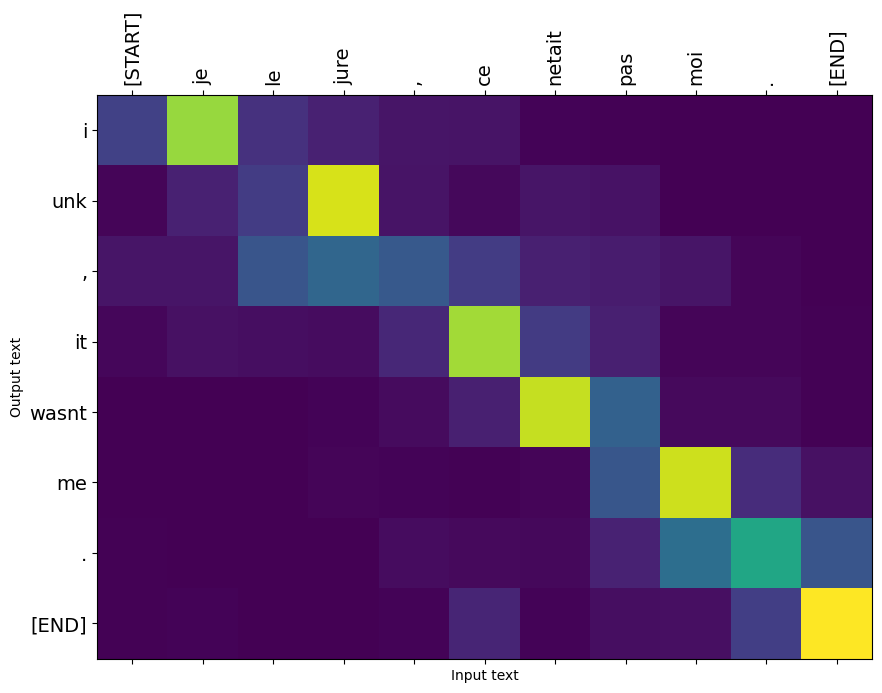

In [ ]:
%%time
# This is my life.
model.plot_attention("Je le jure, ce n'était pas moi.") #I swear, it was not me.

In [ ]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 "I went drinking with one of my boyfriend's friends, and now he's
furious at me." "Was this friend a guy or a girl?" "A guy, obviously.
Why would I go drinking with his female friends?" "Yeah, you're
right." "His name is Tom. He's really hot, and I really want to go
drinking with him again."


<ipython-input-52-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-52-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


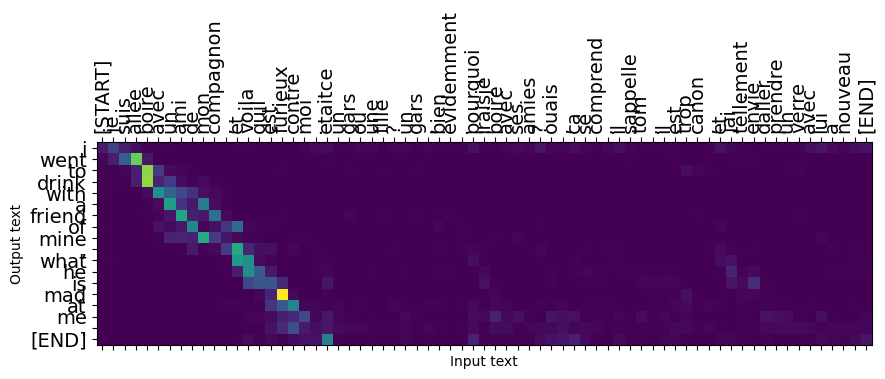

In [ ]:
model.plot_attention(long_text)

In [ ]:
inputs = [
    'Il fait très froid ici.', # "It's really cold here."
    'Ceci est ma vie.', # "This is my life."
    'Sa chambre est un désordre.', # "His room is a mess."
    'J’aime la viande avec des pommes de terre.', # "I like meat with potatoes."
    'Tu as ruiné ma robe de mariée.', # "You have ruined my wedding dress."
    'Tu as de la poudre blanche sur le nez.', # "You have white powder on your nose."
    'Surprise, enfoirés.', # "Surprise, assholes."
]


In [ ]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

its very cold here . 
this is my life . 
his room is a mess . 
i like meat with apples . 
youve ruined my dress . 
you have a white [UNK] on the nose . 
surprise , do you smoke . 

CPU times: user 3.14 s, sys: 37 ms, total: 3.17 s
Wall time: 3.66 s


In [ ]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print(result[3].numpy().decode())
print(result[4].numpy().decode())
print(result[5].numpy().decode())
print()

its very cold here .     
this is my life .     
his room is a mess .    
i like meat with apples .    
youve ruined my dress .     
you have a white [UNK] on the nose . 

CPU times: user 804 ms, sys: 9.96 ms, total: 814 ms
Wall time: 1.02 s
